In [1]:
import os
import torch
import numpy as np

from dataset import PatchDataset
from model import PatchClassifier, ModelHandler
import config
import utils

from pytorch_grad_cam import GradCAM , GradCAMPlusPlus, XGradCAM ,LayerCAM, FullGrad    
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

from PIL import Image
import matplotlib.pyplot as plt

import lovely_tensors as lt

In [2]:
layer_id = 4
method = GradCAM
INF_DICE = 88.24

model = PatchClassifier(
    features_only=config.FEATURES_ONLY, 
    out_classes=config.NUM_CLASSES,
    freeze_encoder=config.FREEZE_ENCODER,
)

ref_dataset = PatchDataset(config.DATA_DIR, config.ATF, preproc=False, augment=False)
dataset = PatchDataset(config.DATA_DIR, config.ATF, preproc=True, augment=False)

mh = ModelHandler(model)
mh.load(os.path.join(config.MODEL_FOLDER, f'{config.CONFIG_ID}_{INF_DICE}.pt'))
model = mh.model.model

model.requires_grad_(True)
model = model.eval()

In [3]:
class ResnetFeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super(ResnetFeatureExtractor, self).__init__()
        self.feature_extractor = torch.nn.Sequential(*list(model.children())[:-1]) # features + avg_pool
                
    def __call__(self, x):
        return self.feature_extractor(x)[:, :, 0, 0]
        
feature_model = ResnetFeatureExtractor(model)

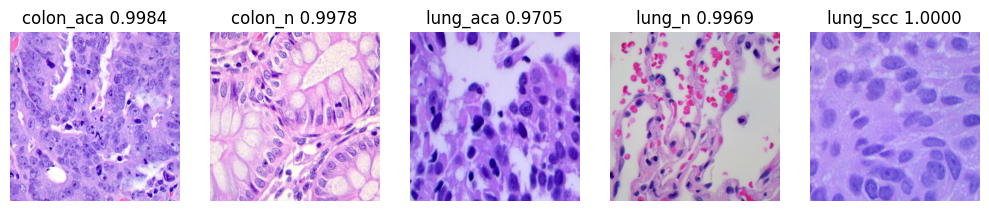

In [4]:
classes = list(dataset.class_to_idx.keys())
class_imgs = {}

np.random.seed(42)
for class_name in classes:
    class_idx = ref_dataset.class_to_idx[class_name]
    class_img_idx = np.random.choice(np.where(np.asarray(dataset.targets) == class_idx)[0])

    img_pil = Image.open(ref_dataset.imgs[class_img_idx])
    img_np_norm = np.asarray(Image.open(dataset.imgs[class_img_idx]).resize(config.INPUT_SIZE)) / 255.0
    input_tensor = dataset[class_img_idx][0].unsqueeze(0).type(torch.FloatTensor)
    target_category = [ClassifierOutputTarget(class_idx)]
    probs = mh.get_probs(img_pil, dataset.idx_to_class)

    class_imgs[class_name] = (img_pil, img_np_norm, input_tensor, class_idx, target_category, probs)

#### plot 5 images in a row
random_class_imgs = [(v[0], k, v[5]) for k, v in class_imgs.items()]
fig, axs = plt.subplots(1, len(random_class_imgs), figsize=(10, 2), constrained_layout=True)
for i, (img, title, probs) in enumerate(random_class_imgs):
    axs[i].imshow(img)
    axs[i].set_title(f"{title} {probs[title]:.4f}")
    axs[i].axis('off')

In [5]:
colon_imgs = {k: v for k, v in class_imgs.items() if 'colon' in k}
lung_imgs = {k: v for k, v in class_imgs.items() if 'lung' in k}

In [6]:
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)

class DifferenceFromConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return 1 - cos(model_output, self.features)

############################################## Colon ##############################################

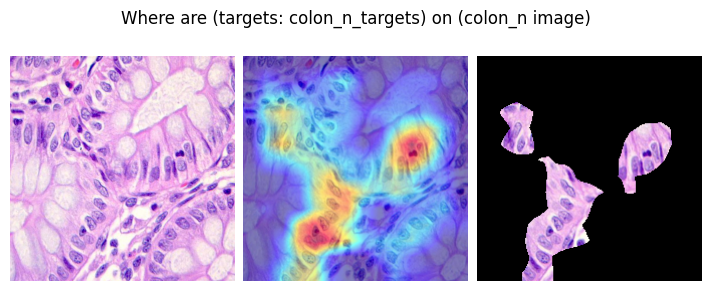

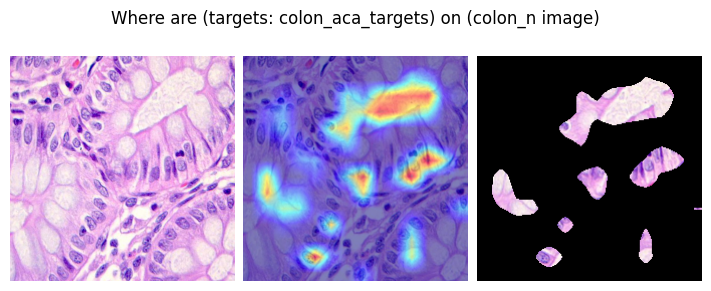

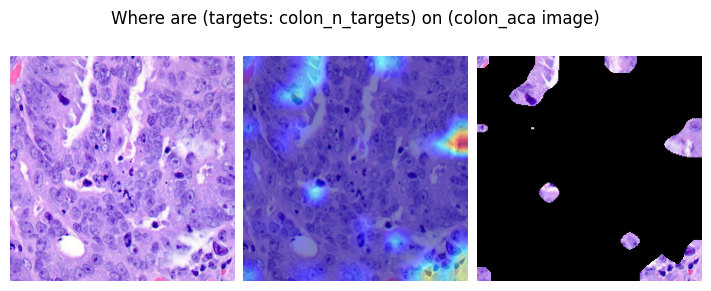

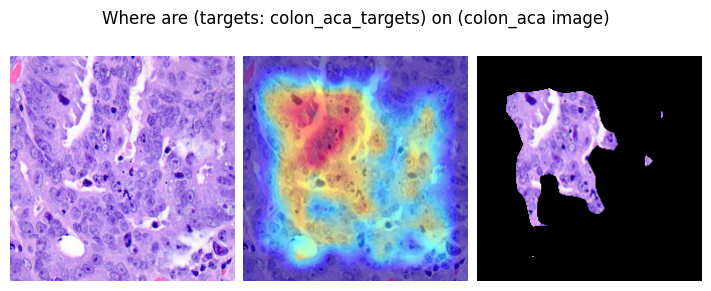

In [8]:
colon_n_targets = [SimilarityToConceptTarget(feature_model(colon_imgs['colon_n'][2])[0, :])]
colon_aca_targets = [SimilarityToConceptTarget(feature_model(colon_imgs['colon_aca'][2])[0, :])]

for img_type in ['colon_n', 'colon_aca']:
    img_pil, img, img_tensor, _, _, img_probs = colon_imgs[img_type]
    for type_targets in ['colon_n_targets', 'colon_aca_targets']:
        with method(model=feature_model, target_layers=eval(f"[model.layer{layer_id}[-1]]"), use_cuda=False) as cam:
            cam_n = cam(input_tensor=img_tensor, targets=eval(type_targets))[0, :]
            cam_on = show_cam_on_image(img, cam_n, use_rgb=True)
            cam_crop = utils.show_crop_cam_on_image(img, cam_n)

            fig, axs = plt.subplots(1, 3, figsize=(7, 3), constrained_layout=True)
            # fig.suptitle(f"Where are (targets: {type_targets} on ({img_type} image)  | {img_type} class prob: {img_probs[img_type]:4f}")
            fig.suptitle(f"Where are (targets: {type_targets}) on ({img_type} image)")
            axs[0].imshow(img_pil)
            axs[0].axis('off')
            axs[1].imshow(cam_on)
            axs[1].axis('off')
            axs[2].imshow(cam_crop)
            axs[2].axis('off')

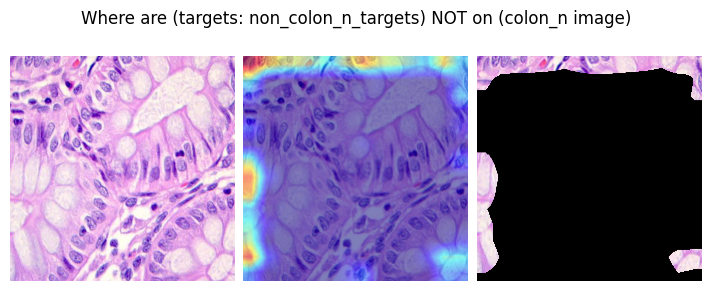

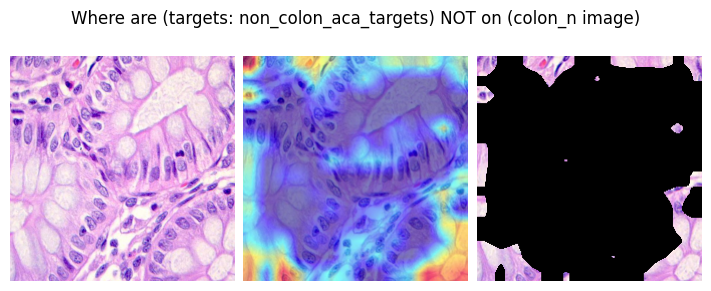

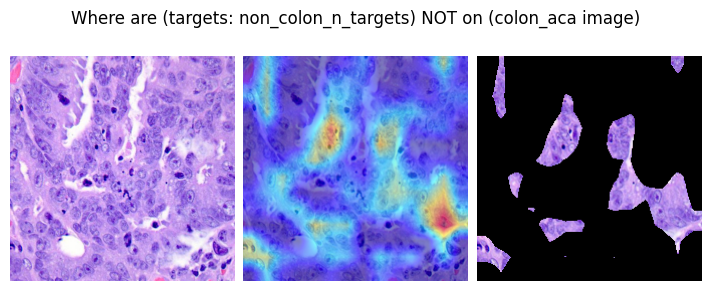

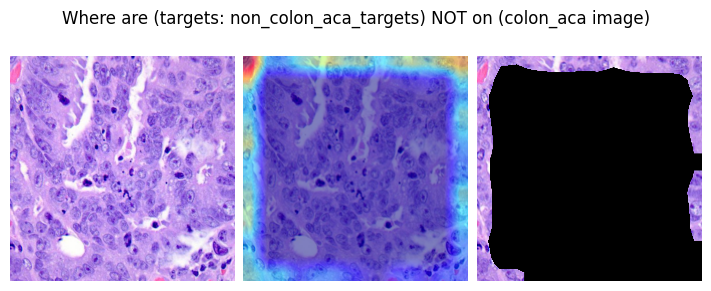

In [9]:
non_colon_n_targets = [DifferenceFromConceptTarget(feature_model(colon_imgs['colon_n'][2])[0, :])]
non_colon_aca_targets = [DifferenceFromConceptTarget(feature_model(colon_imgs['colon_aca'][2])[0, :])]

for img_type in ['colon_n', 'colon_aca']:
    img_pil, img, img_tensor, _, _, img_probs = colon_imgs[img_type]
    for type_targets in ['non_colon_n_targets', 'non_colon_aca_targets']:
        with method(model=feature_model, target_layers=eval(f"[model.layer{layer_id}[-1]]"), use_cuda=False) as cam:
            cam_n = cam(input_tensor=img_tensor, targets=eval(type_targets))[0, :]
            cam_on = show_cam_on_image(img, cam_n, use_rgb=True)
            cam_crop = utils.show_crop_cam_on_image(img, cam_n)

            fig, axs = plt.subplots(1, 3, figsize=(7, 3), constrained_layout=True)
            # fig.suptitle(f"Where are --{type_targets}-- NOT on --{img_type}-- image | {img_type} class prob: {img_probs[img_type]:4f}")
            fig.suptitle(f"Where are (targets: {type_targets}) NOT on ({img_type} image)")
            axs[0].imshow(img_pil)
            axs[0].axis('off')
            axs[1].imshow(cam_on)
            axs[1].axis('off')
            axs[2].imshow(cam_crop)
            axs[2].axis('off')

################################## Lung ##################################

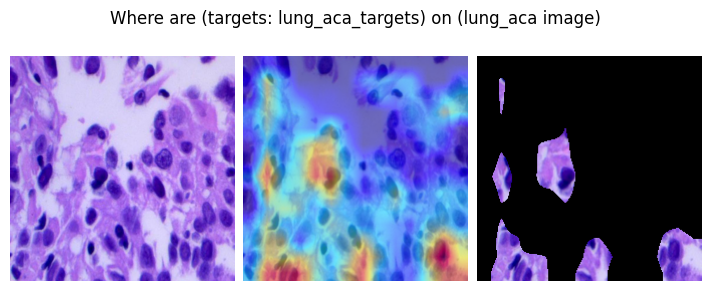

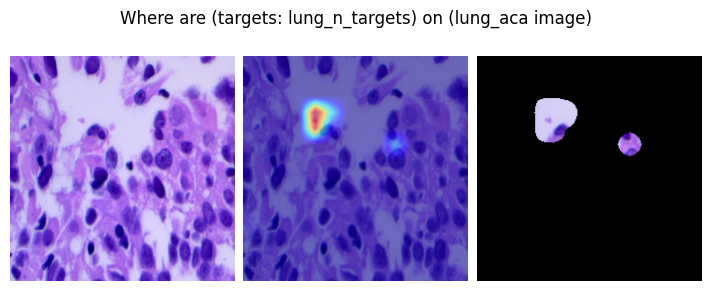

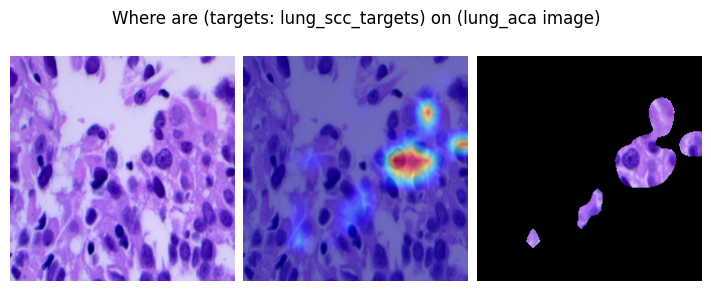

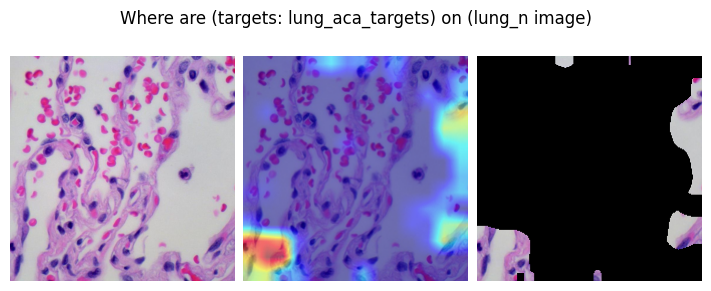

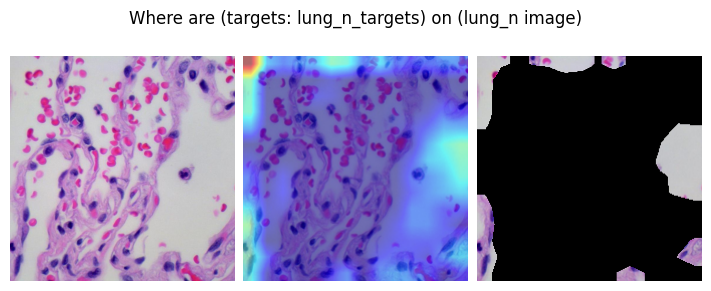

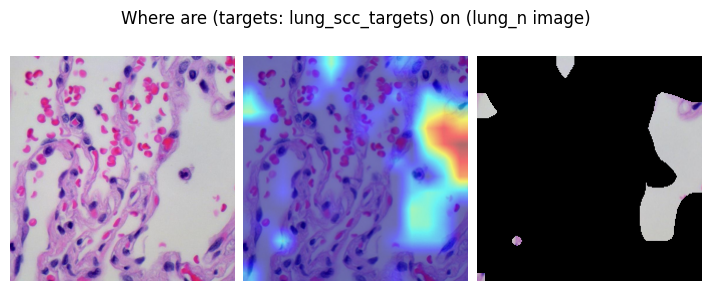

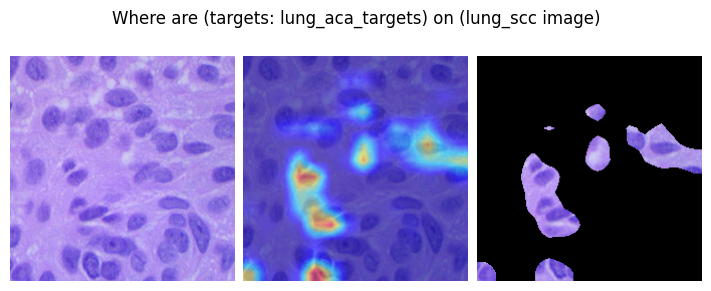

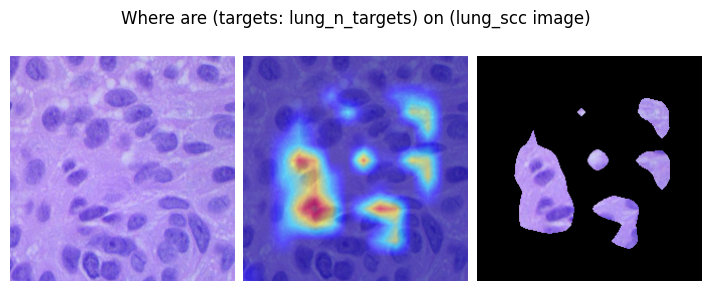

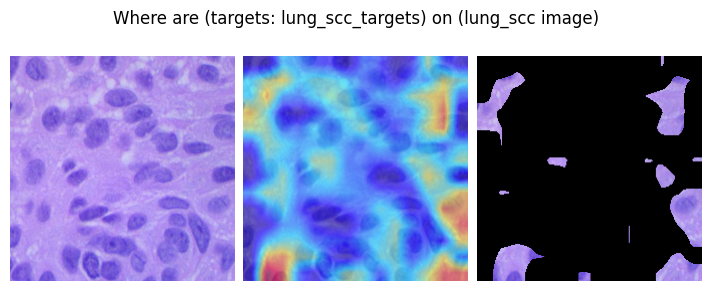

In [10]:
lung_aca_targets = [SimilarityToConceptTarget(feature_model(lung_imgs['lung_aca'][2])[0, :])]
lung_n_targets = [SimilarityToConceptTarget(feature_model(lung_imgs['lung_n'][2])[0, :])]
lung_scc_targets = [SimilarityToConceptTarget(feature_model(lung_imgs['lung_scc'][2])[0, :])]

for img_type in ['lung_aca', 'lung_n', 'lung_scc']:
    img_pil, img, img_tensor, _, _, img_probs = lung_imgs[img_type]
    for type_targets in ['lung_aca_targets', 'lung_n_targets', 'lung_scc_targets']:
        with method(model=feature_model, target_layers=eval(f"[model.layer{layer_id}[-1]]"), use_cuda=False) as cam:
            cam_n = cam(input_tensor=img_tensor, targets=eval(type_targets))[0, :]
            cam_on = show_cam_on_image(img, cam_n, use_rgb=True)
            cam_crop = utils.show_crop_cam_on_image(img, cam_n)

            fig, axs = plt.subplots(1, 3, figsize=(7, 3), constrained_layout=True)
            # fig.suptitle(f"Where are --{type_targets}-- on --{img_type}-- image | {img_type} class prob: {img_probs[img_type]:4f}")
            fig.suptitle(f"Where are (targets: {type_targets}) on ({img_type} image)")
            axs[0].imshow(img_pil)
            axs[0].axis('off')
            axs[1].imshow(cam_on)
            axs[1].axis('off')
            axs[2].imshow(cam_crop)
            axs[2].axis('off')

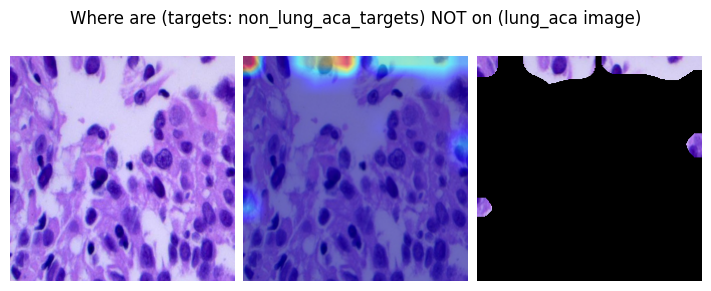

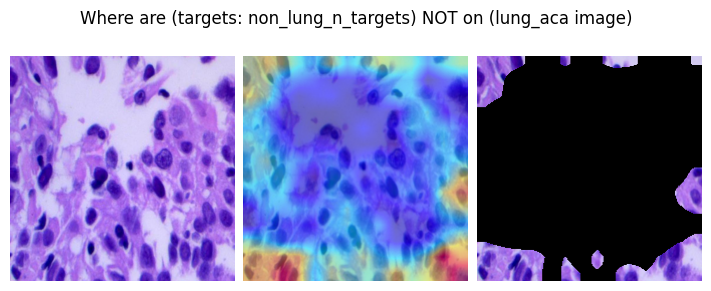

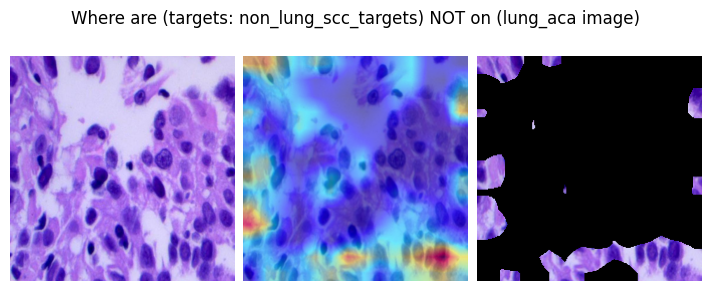

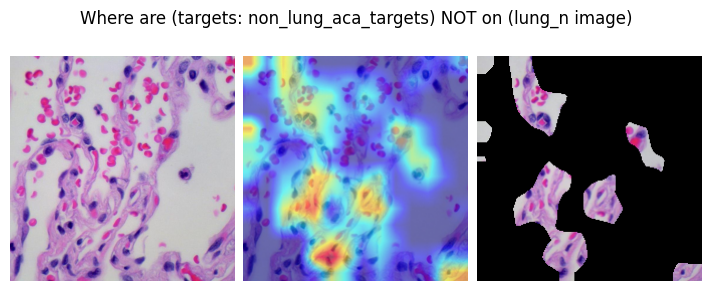

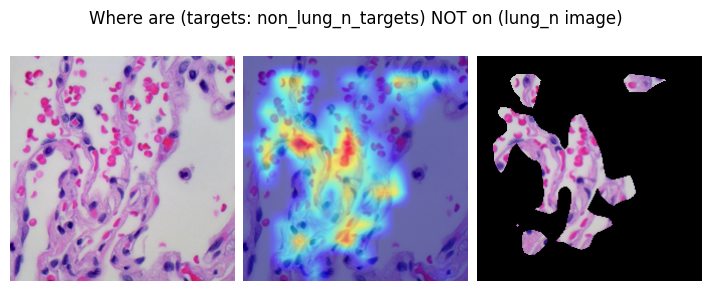

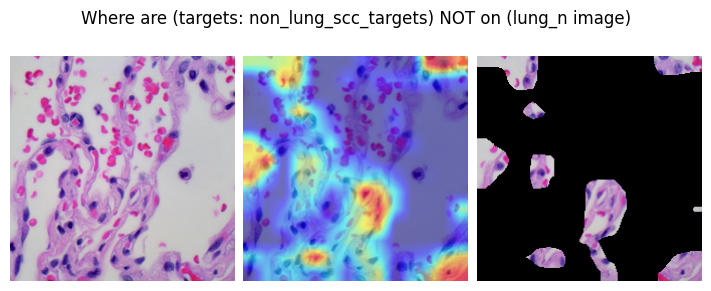

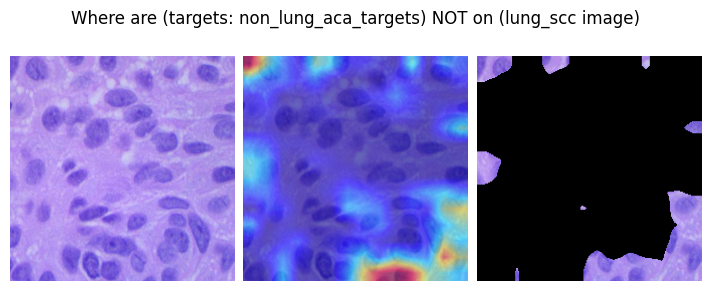

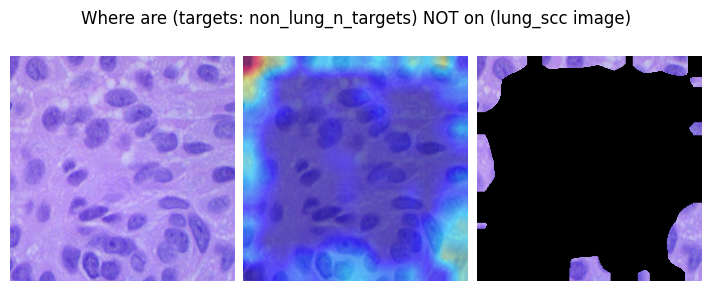

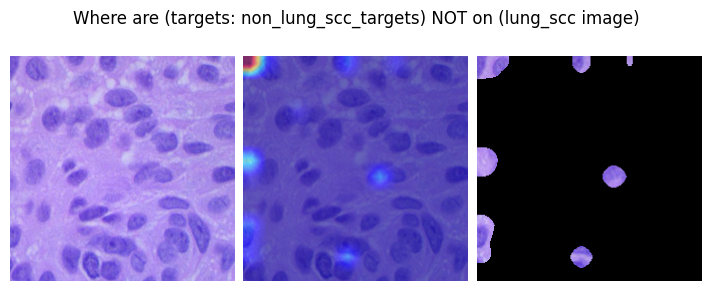

In [11]:
non_lung_aca_targets = [DifferenceFromConceptTarget(feature_model(lung_imgs['lung_aca'][2])[0, :])]
non_lung_n_targets = [DifferenceFromConceptTarget(feature_model(lung_imgs['lung_n'][2])[0, :])]
non_lung_scc_targets = [DifferenceFromConceptTarget(feature_model(lung_imgs['lung_scc'][2])[0, :])]

for img_type in ['lung_aca', 'lung_n', 'lung_scc']:
    img_pil, img, img_tensor, _, _, img_probs = lung_imgs[img_type]
    for type_targets in ['non_lung_aca_targets', 'non_lung_n_targets', 'non_lung_scc_targets']:
        with method(model=feature_model, target_layers=eval(f"[model.layer{layer_id}[-1]]"), use_cuda=False) as cam:
            cam_n = cam(input_tensor=img_tensor, targets=eval(type_targets))[0, :]
            cam_on = show_cam_on_image(img, cam_n, use_rgb=True)
            cam_crop = utils.show_crop_cam_on_image(img, cam_n)

            fig, axs = plt.subplots(1, 3, figsize=(7, 3), constrained_layout=True)
            # fig.suptitle(f"Where are --{type_targets}-- NOT on --{img_type}-- image | {img_type} class prob: {img_probs[img_type]:4f}")
            fig.suptitle(f"Where are (targets: {type_targets}) NOT on ({img_type} image)")
            axs[0].imshow(img_pil)
            axs[0].axis('off')
            axs[1].imshow(cam_on)
            axs[1].axis('off')
            axs[2].imshow(cam_crop)
            axs[2].axis('off')